### Part 1:
1. Add code to `AddGaussianNoise` transform class
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, or N(0, 0.3).
  * Clip the values to be between 0 and 1.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with titles, label, etc. Create separate dataloaders and use ``zip`, [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

### Please create an gif named folder in you files section of colab so that you can save the gif videos of the chanfe of VAE images wrt iteration/epochs

In [1]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


# 1. Add code to AddGaussianNoise transform class

class AddGaussianNoise(object):
  ###########################   <CODE>  ############################
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
# Add additive Gaussian noise to the batch of input images
# (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, or N(0, 0.3).

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)  

  #########################  <END CODE>  #########################

transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.5122623443603516
-1.0760372877120972


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


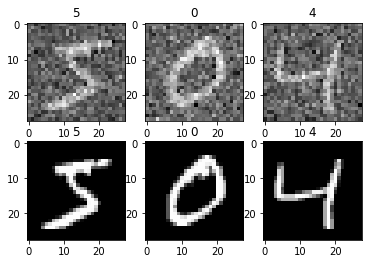

In [2]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 512, 1
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################  <CODE>  ############################ 
# Plot 3 training images and thier noisy counterpoparts
fig , ax = plt.subplots(2,3)
i=0  
for image_batch1 ,labels1 in train_dataset_noisy:
  if(i<3):
    ax[0,i].imshow(image_batch1[0],cmap='gray')
    ax[0,i].set_title(labels1)
    i+=1
  else:
    break
i=0
for image_batch2 ,labels2 in train_dataset_original:
  if(i<3):
    ax[1,i].imshow(image_batch2[0],cmap='gray')
    ax[1,i].set_title(labels2)
    i+=1
  else:
    break

plt.show()     
#########################  <END CODE>  ############################

### Part 2
1. Build an autoencoder neural network structure with encoders and decoders. network can have convolutional or transpose layers. Run on the GPU.
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value.loss on the test data should be lower than 20.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [3]:
###########################   <CODE>  ############################
import torch
import torch.nn as nn
#Define the Convolutional Autoencoder

# 1. Build an autoencoder neural network structure with encoders and decoders. network can have convolutional or transpose layers. Run on the GPU.

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #creating an encoder
        # We will ve adding Convolutional layer in 
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )

        #Creating a decoder  we will be adding Transpose Convolutional layers in Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), #transpose conv layers1
            nn.ReLU(),  # Adding relu
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), #transpose conv layers2
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), #transpose conv layers3
            nn.Sigmoid()
        )
    #Creating an Forward network to call the encoder and decoder
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
#########################  <END CODE>  ############################

In [4]:
# 2 . Loss = Train your denoising autoencoder model with appropriate optimiz 
#      and MSE loss function. loss function should be computed between the output 
#     of the noisy images and the clean images, i.e.,  L(x,g(f(x~))) , where  x~=x+ϵ  is the noisy image and  ϵ  is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value.loss on the test data should be lower than 20.

def train(model, num_epochs=5, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loss = []
    test_loss = []  
    outputs = []

    # Dirty image is the image with the noise
    # Clean image is Original image
    # Recon is the image that is reconstructed with our model given above
    # Also Train_loss and test_loss is for saving losses 
    for epoch in range(num_epochs):
        for dirty, clean in tqdm(train_loader):
          dirty = dirty.to(device)
          clean = clean.to(device)
          recon = model(dirty)
          loss = criterion(recon.squeeze(), clean.squeeze()) # Same way given in the above Comment Number 2
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          train_loss.append(loss)

        for dirty,clean in tqdm(test_loader):
          dirty = dirty.to(device)
          clean = clean.to(device)
          recon = model(dirty)
          loss = criterion(recon.squeeze(),clean.squeeze())   # Same way given in the above Comment Number 2
          test_loss.append(loss)

        print('Training Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(train_loss[epoch])))
        print('Test Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(test_loss[epoch])))
        outputs.append((epoch, clean, recon),)
    return outputs

In [5]:
# Traning of our model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Autoencoder().to(device)
max_epochs = 3 # Used only 3 epochs that can be changed 
outputs = train(model1, num_epochs=max_epochs) # At the end of 3rd epoch we get test loss: 0.0038 and training loss: 0.2164

100%|██████████| 10000/10000 [00:12<00:00, 779.87it/s]


Training Epoch:1, Loss:0.1925
Test Epoch:1, Loss:0.0546


100%|██████████| 10000/10000 [00:12<00:00, 793.28it/s]


Training Epoch:2, Loss:0.1922
Test Epoch:2, Loss:0.0872


100%|██████████| 10000/10000 [00:14<00:00, 697.82it/s]

Training Epoch:3, Loss:0.1912
Test Epoch:3, Loss:0.0367


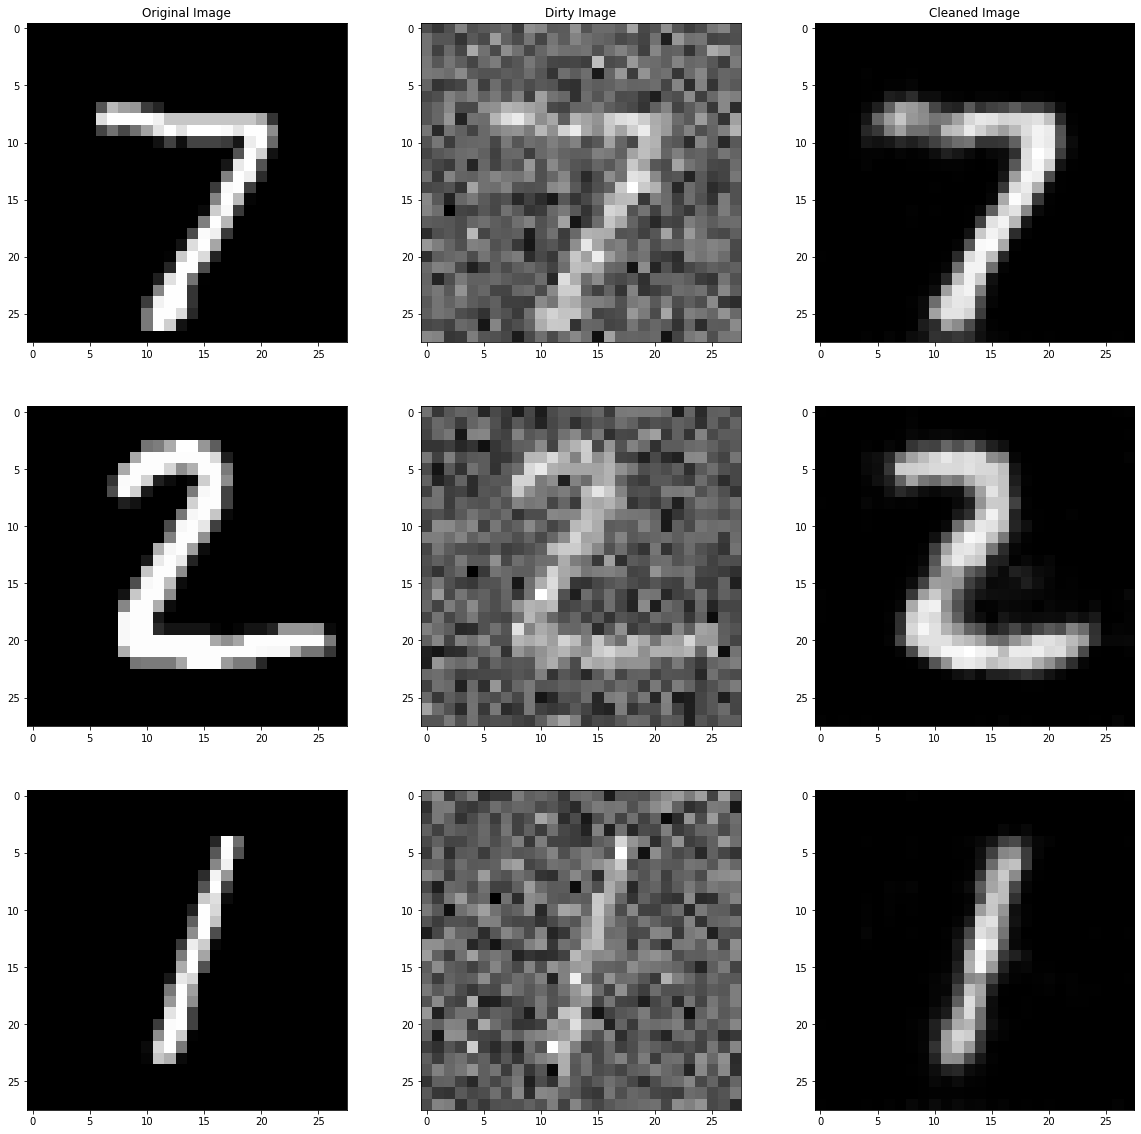

In [6]:
# 3. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test
#    images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

f,axes= plt.subplots(3,3,figsize=(20,20)) # 3*3 Grid with image orignal/Dirty(added noise)/resconstruced ploted

#naming the titles of images
axes[0,0].set_title("Original Image") #naming the titles of images
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

i=0
# Selecting any 3 image and plotting the outputs and graph as per mentioned in point 3
for dirty,clean in test_loader:
  if(i<3):
    dirty = dirty.to(device)
    clean = clean.to(device)

    output=model1(dirty) # taking output  used to balance the dimension of the wieghts

    #Transforming the output so that we can plot
    output=output.view(1,28,28)
    output=output.permute(1,2,0).squeeze(2) # Reducing dims
    output=output.detach().cpu().numpy()    #Creating to numpy array

    dirty=dirty.detach().cpu().numpy()

    clean=clean.detach().cpu().numpy()    

    axes[i,0].imshow(clean.squeeze(),cmap="gray")
    axes[i,1].imshow(dirty.squeeze(),cmap="gray")
    axes[i,2].imshow(output,cmap="gray")

    i+=1

  else:
    break  

### Part 3
1. Import necessary packages
2. Load the MNIST data and specify the devise
3. Secify the device.

In [7]:
###########################   <CODE>  ############################
# 1. Import necessary packages
from tqdm import tqdm
import torch 
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
to_pil_image = transforms.ToPILImage()
import torch.nn.functional as F

batch_size = 64 # batch size can be changed as per convience

# 2. LOading the dataset

# Resizing the dataset and converting to tensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)


# 3. Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#########################  <END CODE>  ############################

In [8]:
# This cell is for extra you can remove it if you want
# It does is that is saves a small video(GIF) of the change of  VAE reconstruction wrt to iteration/epoch and saves it in gif folder please make gir folder before 
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('/content/gif.gif', imgs)  #IMPORTANT  # Please make an folder in you files section named gif before running this cell
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"/content/images{epoch}.jpg") #This basically creates an VAE reconstruction of all the images in grid and saves it

# TO see all the images and gif it is availble in you fies section of Colab once you run all the cells    

### Part 4: 
Construct your loss function.
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
build the VAE (variational autoencoder) model satisfying following conditions
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1. loss is in https://arxiv.org/pdf/1312.6114.pdf. The reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 
4. The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 
5. Write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms. The function should return two loss arrays).visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [9]:
def vae_loss(image,mu, log_var,output):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <CODE>  ###########################

  # 3. The reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
  #    See torch.nn.functional.binary_cross_entropy. You should use the sum reduction of the loss to sum the loss over all the pixels.
  criterion = nn.BCELoss(reduction='sum')
  reconstruction_loss = criterion(output,image)
  # 4. The second part is the KL-Divergence between your model's approximate posterier  qf(z|x)  and the model prior  pg(z) 
  #    If we assume  pg(z)  is a standard normal distribution and  qf(z|x)  
  #    is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above  
  #    KL(qf(z|x),pg(z))=−12∑dj=1(1+log(σ2j)−μ2j−σ2j) .

  # KL divergence loss 
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  # Total loss = 50% rec + 50% KL divergence loss
  return reconstruction_loss,KLD   # Returning the reconstruction_loss and the kl_loss which will be used to calculate Negative Elbow while training
  #########################  <END CODE>  ############################

### Part 4:
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. Calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`. Use the reparametrization trickto backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var` which will be fed into reparameterize.



In [10]:
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

# 1. Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.

class our_VAE(nn.Module):
  def __init__(self): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    ###########################   <CODE>  ############################
    # define the transformations for your encoder and decoder
    # Here we will initilaize our Encoder and Decoder layer and call it later in function
    # I have used 4 encoder to 4 decoder model
    # encoder
    # For encoder we will use Normal Convolutional layer
    # for enc1 i.e encoder 1 we take input as image_channel =1 because out MNIST data is gray it can vary according to dataset

    self.enc1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1)

    self.enc2 = nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,stride=2, padding=1)

    self.enc3 = nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,stride=2, padding=1)

    self.enc4 = nn.Conv2d(in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size,stride=2, padding=0)
  
    # fully connected layers for learning representations
    # Here we will intialize the Fully connected layers 
    self.fc1 = nn.Linear(64, 128)
    self.fc_mu = nn.Linear(128, latent_dim)
    self.fc_log_var = nn.Linear(128, latent_dim)
    self.fc2 = nn.Linear(latent_dim, 64)

    # Same way like encoder we will initialize out decoder layer so that we can call it later
    # decoder 
    # for decoder we will use Convolutional tanspose layers 
    self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,stride=1, padding=0)

    self.dec2 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,stride=2, padding=1)

    self.dec3 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,stride=2, padding=1)

    self.dec4 = nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,stride=2, padding=1)
    #########################  <END CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
# 2. Inside the reparameterize function you job is to output a latent vector.
#   Calculate the standard deviation std from the log variance variable log_var (i.e., compute  σ  from  log(σ2)
#    then generate the vector in Gaussian distribution with mu and std. Use the reparametrization trickto backpropagate through this random step.

    ###########################   <CODE>  ############################
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling
    #########################  <END CODE>  ############################
    return sample

  def encoder(self, x):
    """
    :param x: input distribution

    first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <CODE>  ############################
    # encoding
    # Here we will call the encoders that we initialized earlier and also calculated mu and log_var
    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = F.relu(self.enc4(x))
    batch, _, _, _ = x.shape
    x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
    hidden = self.fc1(x)
    # get `mu` and `log_var`
    mu = self.fc_mu(hidden)
    log_var = self.fc_log_var(hidden)
    # get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)
    z = self.fc2(z)
    z = z.view(-1, 64, 1, 1)

    #########################  <END CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    compute the output x given latent samples z
    """

    ###########################   <CODE>  ############################
    # here we will call the intialized decoder 

    x = F.relu(self.dec1(z))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = torch.sigmoid(self.dec4(x))

    #########################  <END CODE>  ###########################
    return x

  def forward(self, x):
    """
    :param x: input variables

    compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

# 3. nside the forward function you should extract the mu and log_var from the latent representation after the encoder. The output of encoder should be in the dimension [batch_size x 2 x latent_feature], which includes a mean and log variance for each latent feature and for each instance in the batch.
#    Note that the second dimension has value 2, so you need to split this tensor into two components, one called mu and the other called log_var which will be fed into reparameterize.

    ###########################   <CODE>  ############################
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)    
    #########################  <END CODE>  ###########################

    
    return x, mu, log_var

### Part 5: 
1. Train your model with an appropriate optimizer and the above loss function. Train the model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. SHow three pairs of images where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and create a plot with three curves using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. Lable the legend, x-label and y-label.



In [11]:
# Here we will define our traning model so that we can call it later for traning of our dataset
def train(model, dataloader, dataset, device, optimizer):
    model.train()
    running_loss = 0.0
    counter = 0
    batch_NElbow = []
    batch_KLD = []
    batch_recon_loss = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)): # Usinq tqdm to keep track of the iteration through dataset
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data) ##Gettnig output from our model
        recon_loss,KLD = vae_loss(data,mu,logvar,reconstruction) #Gettnig the reconstruction loss and K Divergence loss
        loss = recon_loss+KLD
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

        if((i+1)%10==0):  # 3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches
          batch_NElbow.append(loss)
          batch_KLD.append(KLD)
          batch_recon_loss.append(recon_loss)         
    train_loss = running_loss / counter 
    return train_loss,batch_NElbow,batch_KLD,batch_recon_loss

In [12]:
def validate(model, dataloader, dataset, device):
    model.eval()
    running_loss = 0.0
    counter = 0
    batch_NElbow = []
    batch_KLD = []
    batch_recon_loss = []    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)): # Usinq tqdm to keep track of the iteration through dataset
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data) #Getting output from our model
            recon_loss,KLD = vae_loss(data,mu,logvar,reconstruction) #Getting the reconstruction loss and K Divergence loss
            loss = recon_loss+KLD  # The Negative Elbow Loss the formula is mentioned in the part 4 vae_loss comment
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction

            if((i+1)%10==0): # 3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches
              batch_NElbow.append(loss)
              batch_KLD.append(KLD)
              batch_recon_loss.append(recon_loss) 

    val_loss = running_loss / counter
    return val_loss, recon_images,batch_NElbow,batch_KLD,batch_recon_loss

In [13]:
###########################   <CODE>  ############################

# initialize the model
model = our_VAE().to(device)
# set the learning parameters
# set the learning parameters
lr = 0.001
epochs = 5
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)  #Train your model with an appropriate optimizer and the above loss function. Train the model with enough epochs so that your loss reaches a relatively steady value.

# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

# Below lists are to save the losses obtained from the training and calidation

# Below lists are to save the losses per total batch/10 we get

elbow_train = []
kld_train = []
recon_train = []

elbow_test = []
kld_test = []
recon_test = []


for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,a,b,c = train(
        model, trainloader, trainset, device, optimizer
    )
    elbow_train.append(a)
    kld_train.append(b)
    recon_train.append(c)

    valid_epoch_loss, recon_images,a,b,c = validate(
        model, testloader, testset, device
    )

    elbow_test.append(a)
    kld_test.append(b)
    recon_test.append(c)

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    image_to_vid(grid_images)
    # save the loss plots to disk
    print('TRAINING COMPLETE FOR EPOCH:{}'.format(i+1))
#########################  <END CODE>  ###########################

Epoch 1 of 5


938it [00:57, 16.36it/s]
157it [00:04, 37.30it/s]                         


Train Loss: 14925.4047
Val Loss: 11504.8681
TRAINING COMPLETE FOR EPOCH:4
Epoch 2 of 5


938it [00:57, 16.28it/s]                         
157it [00:04, 38.13it/s]                         


Train Loss: 11176.4237
Val Loss: 10873.1562
TRAINING COMPLETE FOR EPOCH:4
Epoch 3 of 5


938it [00:57, 16.24it/s]                         
157it [00:04, 38.59it/s]                         


Train Loss: 10664.1211
Val Loss: 10306.9818
TRAINING COMPLETE FOR EPOCH:4
Epoch 4 of 5


938it [00:57, 16.17it/s]                         
157it [00:04, 38.41it/s]                         


Train Loss: 10254.8556
Val Loss: 10046.2897
TRAINING COMPLETE FOR EPOCH:4
Epoch 5 of 5


938it [00:57, 16.30it/s]
157it [00:04, 38.06it/s]                         

Train Loss: 10046.7183
Val Loss: 9891.3213
TRAINING COMPLETE FOR EPOCH:4


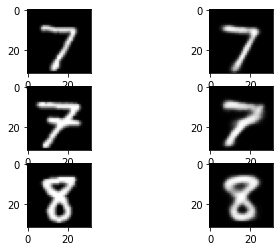

In [14]:
# 2. Visualize your result. SHow three pairs of images where each pair consists of an original test image and its VAE reconstructed version.
# We already have the Reconstruced images in Image grid
i=0
fig,ax = plt.subplots(3,2)
for data,label in testloader:
  i+=1
  if i==4:
    break

  data = data.to(device)
  reconstruction, mu, logvar = model(data)

  data = data.detach().numpy()
  reconstruction = reconstruction.detach().numpy()
  
  ax[i-1,0].imshow(data[0][0],cmap='gray')
  ax[i-1,1].imshow(reconstruction[0][0],cmap='gray')

plt.show()
 # Below you can see that out VAE model output and original data   

For the Epoch 1


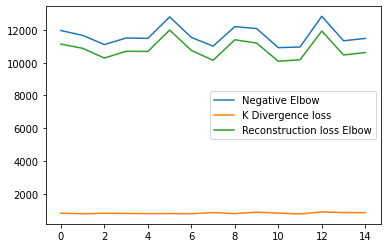

For the Epoch 2


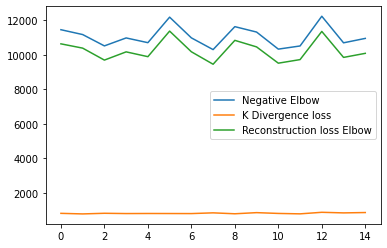

For the Epoch 3


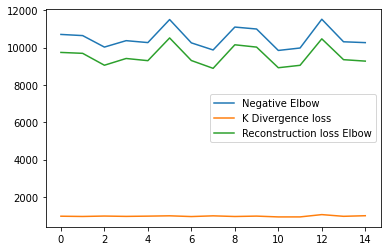

For the Epoch 4


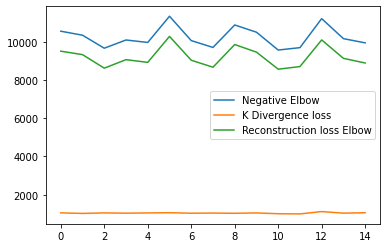

For the Epoch 5


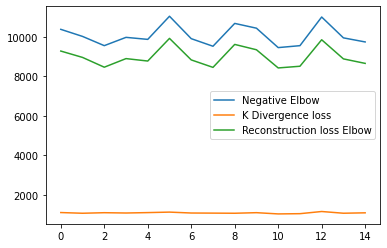

In [15]:
# 4. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and create a plot with three curves using matplotlib.pyplot.plot.
#   Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. Lable the legend, x-label and y-label.'''

# We have saved our losses in list so now we will plot the losses w.r.t to epochs
for i in range(epochs):
   print('For the Epoch {}'.format(1+i))
   # Noe x axis should me total number of batches/10 = total
   plt.plot(list(range(int((len(testset)/testloader.batch_size)/10))),elbow_test[i], label='Negative Elbow') #for plotting Negative Elbow
   plt.plot(list(range(int((len(testset)/testloader.batch_size)/10))),kld_test[i], label='K Divergence loss') # for plotting K Divergence
   plt.plot(list(range(int((len(testset)/testloader.batch_size)/10))),recon_test[i], label='Reconstruction loss Elbow') # for plotting Reconstruction loss Elbow
   plt.legend()
   plt.show()
 # WE that 156 total batches so after dividing it with 10 we get 15.6 batch 

### Part 6: 


1. For better visualization, create a VAE with ``latent_features=2``.visualize how latent space changes in the process of training with the given function ``plot_latent``.

2. Train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after each epoch. You should use the test data for plotting this visualization task.


In [16]:
def plot_latent(vae, data_loader, num_batches=100):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      images = images.to(device)
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

In [17]:
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 2 # latent dimension for sampling

# 1. Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.

class our_VAE(nn.Module):
  def __init__(self): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    ###########################   <CODE>  ############################
    # define the transformations for your encoder and decoder
    # Here we will initilaize our Encoder and Decoder layer and call it later in function
    # I have used 4 encoder to 4 decoder model
    # encoder
    # For encoder we will use Normal Convolutional layer
    # for enc1 i.e encoder 1 we take input as image_channel =1 because out MNIST data is gray it can vary according to dataset
    
    self.enc1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1)

    self.enc2 = nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,stride=2, padding=1)

    self.enc3 = nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,stride=2, padding=1)

    self.enc4 = nn.Conv2d(in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size,stride=2, padding=0)
  
    # fully connected layers for learning representations
    # Here we will intialize the Fully connected layers 
    self.fc1 = nn.Linear(64, 128)
    self.fc_mu = nn.Linear(128, latent_dim)
    self.fc_log_var = nn.Linear(128, latent_dim)
    self.fc2 = nn.Linear(latent_dim, 64)

    # Same way like encoder we will initialize out decoder layer so that we can call it later
    # decoder 
    # for decoder we will use Convolutional tanspose layers 
    self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,stride=1, padding=0)

    self.dec2 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,stride=2, padding=1)

    self.dec3 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,stride=2, padding=1)

    self.dec4 = nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,stride=2, padding=1)
    #########################  <END CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
# 2. Inside the reparameterize function you job is to output a latent vector.
#   Calculate the standard deviation std from the log variance variable log_var (i.e., compute  σ  from  log(σ2)
#    then generate the vector in Gaussian distribution with mu and std. Use the reparametrization trickto backpropagate through this random step.

    ###########################   <CODE>  ############################
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling
    #########################  <END CODE>  ############################
    return sample

  def encoder(self, x):
    """
    :param x: input distribution

    first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <CODE>  ############################
    # encoding
    # Here we will call the encoders that we initialized earlier and also calculated mu and log_var
    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = F.relu(self.enc4(x))
    batch, _, _, _ = x.shape
    x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
    hidden = self.fc1(x)
    # get `mu` and `log_var`
    mu = self.fc_mu(hidden)
    log_var = self.fc_log_var(hidden)
    # get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)
    z = self.fc2(z)
    z = z.view(-1, 64, 1, 1)

    #########################  <END CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    compute the output x given latent samples z
    """

    ###########################   <CODE>  ############################
    # here we will call the intialized decoder 

    x = F.relu(self.dec1(z))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = torch.sigmoid(self.dec4(x))

    #########################  <END CODE>  ###########################
    return x

  def forward(self, x):
    """
    :param x: input variables

    compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

# 3. nside the forward function you should extract the mu and log_var from the latent representation after the encoder. The output of encoder should be in the dimension [batch_size x 2 x latent_feature], which includes a mean and log variance for each latent feature and for each instance in the batch.
#    Note that the second dimension has value 2, so you need to split this tensor into two components, one called mu and the other called log_var which will be fed into reparameterize.

    ###########################   <CODE>  ############################
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)    
    #########################  <END CODE>  ###########################

    
    return x, mu, log_var

Epoch 1 of 5


938it [00:56, 16.46it/s]                         
157it [00:04, 38.87it/s]                         


Train Loss: 15840.7727
Val Loss: 13954.4166
TRAINING COMPLETE FOR EPOCH:5


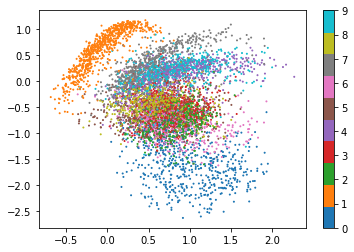

Epoch 2 of 5


938it [00:58, 16.13it/s]                         
157it [00:04, 38.41it/s]                         


Train Loss: 13749.5437
Val Loss: 13426.9725
TRAINING COMPLETE FOR EPOCH:5


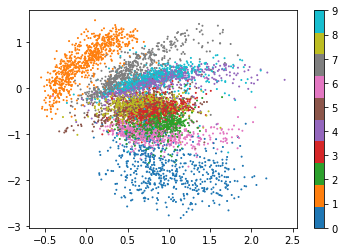

Epoch 3 of 5


938it [00:58, 15.94it/s]
157it [00:04, 37.76it/s]                         


Train Loss: 13393.5577
Val Loss: 13183.8508
TRAINING COMPLETE FOR EPOCH:5


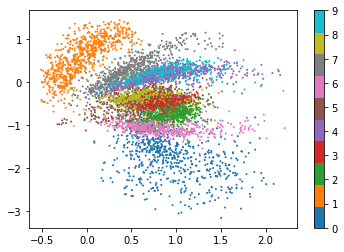

Epoch 4 of 5


938it [00:59, 15.77it/s]                         
157it [00:04, 37.44it/s]                         


Train Loss: 13190.2501
Val Loss: 13031.1622
TRAINING COMPLETE FOR EPOCH:5


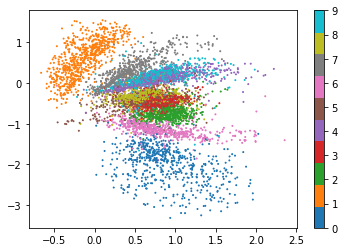

Epoch 5 of 5


938it [00:59, 15.69it/s]
157it [00:04, 36.72it/s]                         


Train Loss: 13050.5720
Val Loss: 12916.9348
TRAINING COMPLETE FOR EPOCH:5


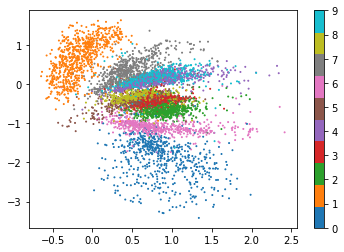

In [18]:
###########################   <CODE>  ############################
# initialize the model
model = our_VAE().to(device)
# set the learning parameters
# set the learning parameters
lr = 0.001
epochs = 5
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr) 

# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

# Below lists are to save the losses obtained from the training and calidation
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,a,b,c = train(
        model, trainloader, trainset, device, optimizer
    )

    valid_epoch_loss, recon_images,a,b,c = validate(
        model, testloader, testset, device
    )

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    image_to_vid(grid_images)
    # save the loss plots to disk
    print('TRAINING COMPLETE FOR EPOCH:{}'.format(i+1))
    #Plotting the latent to see how it changes as per epochs
    plot_latent(model,testloader)
#########################  <END CODE>  ###########################

### Part 7

1. determine the linear interpolation in the latent space and the original data space (raw pixels).With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. Plot all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. Plot all $x'$ images you get in a 1x11 grid.

In [19]:
# finding the image with label 0
for image,label in test_dataset_original:
  if label==0:
    z0 = image
    break

# finding the image with label 1
for image,label in test_dataset_original:
  if label==1:
    z1 = image
    break  

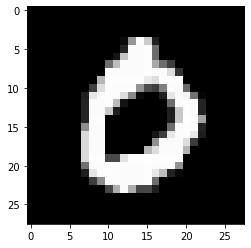

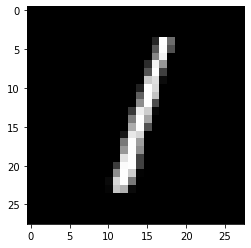

In [20]:
#Plotting our images 0 and 1
plt.imshow(z0[0],cmap='gray')
plt.show()
plt.imshow(z1[0],cmap='gray')
plt.show()

In [21]:
# Here we will be using our auto encoder model model1 which was trained  (We are using AudtoEncoder model if because nothing was specified about which model to use)
# For interpolation we use AudoEncoder that we trained earlier
def interpolate(z0,z1):

# 1. determine the linear interpolation in the latent space and the original data space (raw pixels)
#    With a trained model and test data, sample one  z∼q(z|x)  corresponding to label 0 and 1 separately (two samples in total);
#   this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder.
#   These two latent samples will be denoted  z0  and  z1  respectively.

    z0 = z0.to(device)
    z1 = z1.to(device)
    e1 = model1.encoder(z0[None,...]) # embedding of first image
    e2 = model1.encoder(z1[None,...]) # embedding of second image


    embedding_values = []
    for i in range(0, 10):
        z_dash = e1 * (i/10) + e2 * (10-i)/10   #  2. Compute the linear interpolation of  x0  and  x1  in the following way:  x′=αx1+(1−α)x0 
        embedding_values.append(z_dash)        # where  α=0,0.1,0.2,…,0.9,1.0 . Plot all  x′  images you get in a 1x11 grid.

 
    interpolating_images = []
    for i in embedding_values:
      output = model1.decoder(i)  # 3. Compute the latent linear interpolation of  z0  and  z1  to get  z′  in a similar way. 
                                   #Then, reconstruct the  x′  corresponding to each  z′  using the decoder.
      output=output.view(1,28,28)
      output=output.permute(1,2,0).squeeze(2) # Reducing dims
      output=output.detach().cpu().numpy()
      interpolating_images.append(output)

    return interpolating_images  

img = interpolate(z0,z1)

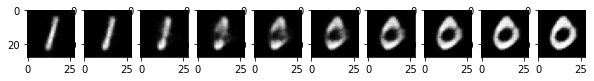

In [22]:
# Plot all  x′  images you get in a 1x11 grid.
plt.figure(figsize=(10, 2))
for i, recon in enumerate(img):
  plt.subplot(2,10,i+1)
  plt.imshow(recon,cmap='gray')
#As you can see it in below grid our image 1 is changinig to 0